Recognize facial expressions using a CNN model on the FER-2013 dataset.
Load and preprocess the FER-2013 dataset.Build a CNN model using Keras/TensorFlow.Train the model on the training set and evaluate it on the test set.Experiment with different CNN architectures to improve accuracy.Visualize the learned feature maps and predictions.
dataset Link--->https://www.kaggle.com/datasets/msambare/fer2013

In [5]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

zip_filename = next(iter(uploaded.keys()))

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall()

print(os.listdir('.'))


Saving archive.zip to archive.zip
['.config', 'archive.zip', 'test', 'train', 'sample_data']


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

In [7]:
train_dir = "/content/train"
test_dir = "/content/test"

In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

Found 22968 images belonging to 7 classes.


In [10]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

Found 5741 images belonging to 7 classes.


In [11]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)


Found 7178 images belonging to 7 classes.


In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1), name='conv2d_1'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', name='conv2d_2'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', name='conv2d_3'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50
)

Epoch 1/50
358/358 [==============================] - 34s 72ms/step - loss: 2.1356 - accuracy: 0.2578 - val_loss: 2.1207 - val_accuracy: 0.1743
Epoch 2/50
358/358 [==============================] - 25s 70ms/step - loss: 1.7063 - accuracy: 0.3438 - val_loss: 1.7340 - val_accuracy: 0.3452
Epoch 3/50
358/358 [==============================] - 24s 66ms/step - loss: 1.5694 - accuracy: 0.3962 - val_loss: 1.5847 - val_accuracy: 0.3820
Epoch 4/50
358/358 [==============================] - 25s 69ms/step - loss: 1.4953 - accuracy: 0.4188 - val_loss: 1.4500 - val_accuracy: 0.4394
Epoch 5/50
358/358 [==============================] - 25s 69ms/step - loss: 1.4404 - accuracy: 0.4481 - val_loss: 1.5202 - val_accuracy: 0.4249
Epoch 6/50
358/358 [==============================] - 24s 67ms/step - loss: 1.4096 - accuracy: 0.4595 - val_loss: 1.5334 - val_accuracy: 0.4370
Epoch 7/50
358/358 [==============================] - 23s 64ms/step - loss: 1.3824 - accuracy: 0.4712 - val_loss: 1.3790 - val_accuracy:

In [15]:
model.save('emotion_detection_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
def visualize_feature_maps(model, layer_name, input_image):
    layer_output = model.get_layer(layer_name).output
    intermediate_model = tf.keras.models.Model(inputs=model.input, outputs=layer_output)
    intermediate_output = intermediate_model.predict(input_image[np.newaxis, ...])

    n_features = intermediate_output.shape[-1]
    size = intermediate_output.shape[1]

    display_grid = np.zeros((size, size * n_features))

    for i in range(n_features):
        feature_map = intermediate_output[0, :, :, i]
        feature_map -= feature_map.mean()
        feature_map /= feature_map.std()
        feature_map *= 64
        feature_map += 128
        feature_map = np.clip(feature_map, 0, 255).astype('uint8')
        display_grid[:, i * size: (i + 1) * size] = feature_map

    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

1/1 [==============================] - 0s 115ms/step


<ipython-input-16-afc0d89786fd>:14: RuntimeWarning: invalid value encountered in divide
  feature_map /= feature_map.std()
<ipython-input-16-afc0d89786fd>:17: RuntimeWarning: invalid value encountered in cast
  feature_map = np.clip(feature_map, 0, 255).astype('uint8')


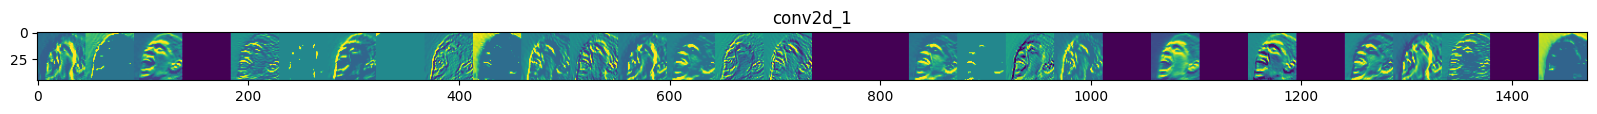

In [17]:
input_image = next(test_generator)[0][0]
layer_name = 'conv2d_1'
visualize_feature_maps(model, layer_name, input_image)

In [18]:
model = tf.keras.models.load_model('emotion_detection_model.h5')

In [19]:
from tensorflow.keras.preprocessing import image

In [20]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [21]:
def predict_emotion(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    max_index = np.argmax(predictions[0])
    predicted_emotion = emotion_labels[max_index]

    plt.imshow(img_array[0].reshape(48, 48), cmap='gray')
    plt.title(f'Predicted emotion: {predicted_emotion}')
    plt.axis('off')
    plt.show()

    return predicted_emotion

1/1 [==============================] - 0s 468ms/step


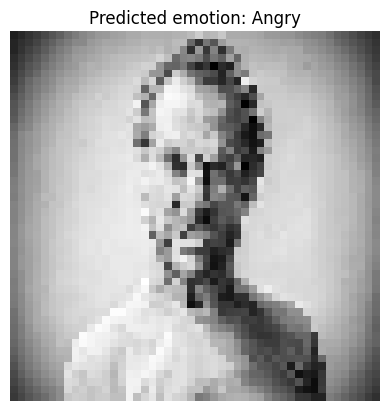

The predicted emotion is: Angry


In [23]:
img_path = '/content/images.jpg'
predicted_emotion = predict_emotion(img_path)
print(f'The predicted emotion is: {predicted_emotion}')